## Simulated experiments

In [1]:
%load_ext rpy2.ipython

## Load Libraries and Visualize Networks

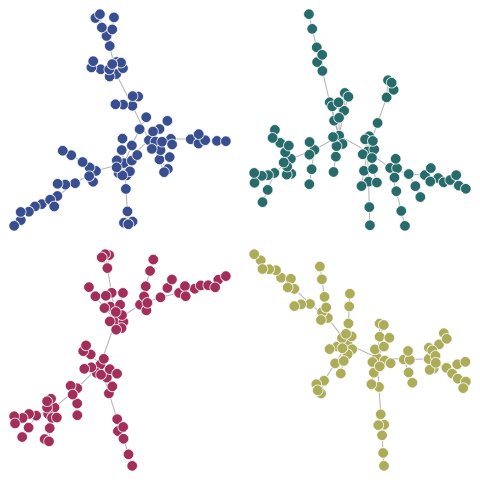

In [16]:
%%R
#install.packages('igraph')
library(igraph)
#install.packages('network')
#install.packages('sna')
library(sna)
#install.packages('ndtv')
library(ndtv)
#install.packages('visNetwork')
library(visNetwork)
library(grf)
library(PAFit)



net.bg <- sample_pa(80)
V(net.bg)$size <- 8
V(net.bg)$frame.color <- "white"
V(net.bg)$color <- "orange"
V(net.bg)$label <- ""
E(net.bg)$arrow.mode <- 0
plot(net.bg)


l <- layout_with_fr(net.bg)
plot(net.bg, layout=l)


plot(net.bg, layout=layout_randomly)
par(mfrow=c(2,2), mar=c(0,0,0,0)) # plot four figures - 2 rows, 2 columns
plot(net.bg, layout=layout_with_fr, vertex.color="#4863A0", vertex.size = 10)
plot(net.bg, layout=layout_with_fr, vertex.color="#307D7E", vertex.size = 10)
plot(net.bg, layout=layout_with_fr, vertex.color="#B3446C", vertex.size = 10)
plot(net.bg, layout=l, vertex.color = "#BAB86C", vertex.size = 10)


## Simulate Data

In [17]:
%%R 

### Build a function that runs 1000 times for a single tree
### that becomes equivalent to the results of 1000 trees
simulate_data <- function(N, cov_dim){
  set.seed(0)
  seeds <- seq(10, 1000, 10)  
  
  
  library("PAFit")
  
  
  p = cov_dim
  # generate a network from the BA model with alpha = 1, N = 1000+2, m = 1
  net <- generate_BA(N = 1000+2, multiple_node = 1, alpha = 1)
  str(net)
  #plot(net)
  
  
  ## basically we have a graph which contains from_id (id of the source) 
  # to to_id (id of the destination)
  #head(net$graph) 
  
  ## we now can calculate a distance matrix - i.e., how many nodes it 
  # takes to get from_id to to_id (so we can measure the closure)
  # the highest correlated ones are with the less distance.
  
  net_data <- as.data.frame(net$graph)
  net_data$dist <- net_data$V1 - net_data$V2
  
  eye <- diag(p)
  tri <- c(net_data$dist)
  length(tri)
  
  b = matrix(0, p, p) 
  b[lower.tri(b, diag=FALSE)] <- tri
  b[upper.tri(b, diag=FALSE)] <- tri
  b <- b + eye
  covar <- matrix(0, p, p)
  
  
  ## now convert distances to a covariance matrix (Yunchuan Kong & TianweiYu, 2018)
  for (i in 1:nrow(b)){
    
    for (j in 1:ncol(b)){
      
      covar[i, j] <- 0.5^b[i, j]
      
    }
  }
  
  print(covar)
  # Extract diagonal elements
  diagonal_elements <- diag(covar)
  
  #  Replace diagonal elements with zones
  diagonal_elements[] <- rep(1,  length(diagonal_elements))
  
  #  Assign modified diagonal elements back to the matrix
  covar <- `diag<-`(covar, diagonal_elements)
  
  ### Now simulate the data
  #N <- 500 #number of obs
  NX <- cov_dim # number of covariates
  
  ## instruments
  mean_X <- rep(0, len = NX)
  #var_X <- crossprod(covar, covar*(NX:1))
  var_X <- covar + diag(3)*0.5

  
  X <- as.matrix(MASS::mvrnorm(N, c(mean_X), var_X))
  
  
  
  #set.seed(30)
  P = rbinom(N, 1, 0.5)
  
  
  ## simulate outcome
  y1 <- 0.5 +  P*(X[, 2]+ 0.5*X[, 1]) + rnorm(N, 0, 1)
  y2 <- 0.5 + P*(X[, 3] + 0.5*X[, 1]) + rnorm(N, 0, 1)
  print(cov(X[, 2]+ 0.5*X[, 1], X[, 3] + 0.5*X[, 1]))
  
  data = as.data.frame(cbind(y1, y2, P, X))
  
  return(data)
  
}



sim_data <- simulate_data(N = 1000, cov_dim = 3)
head(sim_data)


List of 4
 $ graph  : num [1:1000, 1:3] 2 3 4 5 6 7 8 9 10 11 ...
 $ fitness: Named num [1:1002] 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "names")= chr [1:1002] "1" "2" "3" "4" ...
 $ PA     : num [1:57] 1 1 2 3 4 5 6 7 8 9 ...
 $ type   : chr "directed"
 - attr(*, "class")= chr "PAFit_net"
     [,1]  [,2]  [,3]
[1,] 0.50 0.500 0.250
[2,] 0.50 0.500 0.125
[3,] 0.25 0.125 0.500
[1] 1.024162
         y1         y2 P          V4          V5         V6
1 0.8828439 -1.9983620 0  0.06893898  0.09388311 -1.0987592
2 0.3153436 -0.2165878 1  0.52743223 -0.21276663 -0.9173220
3 4.6536467  0.7166862 1  2.70764618  2.20710082  0.3843278
4 1.5456280 -0.8713702 0 -1.10077536 -2.24886012  1.0876725
5 0.2382166 -1.0355719 1 -0.59046362 -0.73261380 -2.4086316
6 0.7104335  3.0157261 1  2.31634823  0.90484229  0.6070273


In addition: Warning messages:
1: In b[lower.tri(b, diag = FALSE)] <- tri :
  number of items to replace is not a multiple of replacement length
2: In b[upper.tri(b, diag = FALSE)] <- tri :
  number of items to replace is not a multiple of replacement length


In [18]:
%%R
########### Construct a multivariate causal forest that saves 1000 results for
#### a single tree grown on the same data
Y <- as.matrix(sim_data[, c(1, 2)])
W <- as.factor(sim_data[, 3])
X <- as.matrix(sim_data[, c(4:ncol(sim_data))])


predictions1 <- list()
predictions2 <- list()

library(grf)
for (i in 1:1000){
  model <- multi_arm_causal_forest(X, Y, W, num.trees = 1, seed = i)
  predictions1[[i]] <- model$predictions[, 1]
  predictions2[[i]] <- model$predictions[, 2]
  
}




# Assuming predictions1 and predictions2 are your bootstrapped lists of vectors
# Each list element is a vector of length N
predictions1_mean <- colMeans(do.call(rbind, predictions1), na.rm = T)
predictions2_mean <- colMeans(do.call(rbind, predictions2), na.rm = T)


temp_list1_var <- list()
temp_list2_var <- list()
temp_list3_cov <- list()


for (i in 1:length(predictions1)){
  
  temp_list1_var[[i]] <- (predictions1[[i]] - predictions1_mean)^2
  temp_list2_var[[i]] <- (predictions2[[i]] - predictions2_mean)^2
  temp_list3_cov[[i]] <- (predictions1[[i]] - predictions1_mean)*(predictions2[[i]] - predictions2_mean)
  
}



predictions1_var <- colMeans(do.call(rbind, temp_list1_var), na.rm = T)
predictions2_var <- colMeans(do.call(rbind, temp_list2_var), na.rm = T)
bootstrapped_cov <- colMeans(do.call(rbind, temp_list3_cov), na.rm = T)


mean(round(bootstrapped_cov, 3)) ### real covariance is 0.125, while estimated mean cov 0.139
round(bootstrapped_cov, 3) ### real covariance is 0.125, while estimated mean cov 0.139


library(ggplot2)
ggplot(data = sim_data, aes(x = X[, 2] + 0.5 * X[, 1], y = X[, 3] + 0.5 * X[, 1])) +
  geom_point(aes(color = "simulated"), alpha = 0.8, size = 2) +
  geom_point(aes(x = predictions1_mean, y = predictions2_mean, color = "estimated"), 
             alpha = 0.8, size = 2) +
  theme_classic() +
  scale_color_manual(values = c("simulated" = "#666362", "estimated" = "#87AFC7"), name = "policy effect") +
  labs(x = "policy effect (first outcome)", y = "policy effect (second outcome)") +
  theme(axis.text = element_text(size = 12))  # Adjust the size (14 is just an example, you can change it)


mean(predictions1_var)


mean(data_final$bootstrapped_cov)

data_final <- as.data.frame(cbind(ate1_true  = X[, 2]+ 0.5*X[, 1], 
                                  ate2_true =  X[, 3]+ 0.5*X[, 1], 
                                  predictions1_mean, predictions2_mean, 
                                  predictions1_var, predictions2_var, bootstrapped_cov))



data_final$cov_binary <- ifelse(data_final$bootstrapped_cov <= 0, "non-positive", "positive")


cov(data_final$ate1_true, data_final$ate2_true)
cov(data_final$predictions1_mean, data_final$predictions2_mean)


head(data_final)
table(data_final$cov_binary)


mean((data_final$ate1_true - data_final$predictions1_mean)^2)
mean((data_final$ate2_true - data_final$predictions2_mean)^2)


library(data.table)
data_final <- as.data.table(data_final)
data_final[, .(covariance = mean(bootstrapped_cov), 
               var_pred1 = mean(predictions1_var), 
               var_pred2 = mean(predictions2_var)), .(cov_binary)]



data_final$var_mean1 <- ifelse(data_final$cov_binary == "positive", 0.3640521, 0.2966197 )
data_final$var_mean2 <- ifelse(data_final$cov_binary == "positive", 0.3655752, 0.3226346 )
data_final$cov_mean <- ifelse(data_final$cov_binary == "positive", 0.08639157 , -0.01717121 )

head(data_final)

     ate1_true  ate2_true predictions1_mean predictions2_mean predictions1_var
         <num>      <num>             <num>             <num>            <num>
1:  0.12835260 -1.0642897        -0.1900877        -0.9177484        0.2472078
2:  0.05094949 -0.6536059        -0.2444243        -0.5575023        0.2749638
3:  3.56092391  1.7381509         2.5078774         1.6546049        0.3768690
4: -2.79924779  0.5372848        -2.3133917         0.2694298        0.2126991
5: -1.02784561 -2.7038634        -1.4150968        -1.7897240        0.3400921
6:  2.06301640  1.7652014         1.8558132         1.6722339        0.3367629
   predictions2_var bootstrapped_cov cov_binary var_mean1 var_mean2   cov_mean
              <num>            <num>     <char>     <num>     <num>      <num>
1:        0.2660852       0.02823650   positive 0.3640521 0.3655752 0.08639157
2:        0.2869059       0.06543589   positive 0.3640521 0.3655752 0.08639157
3:        0.3485086       0.08678028   positive 0.36

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


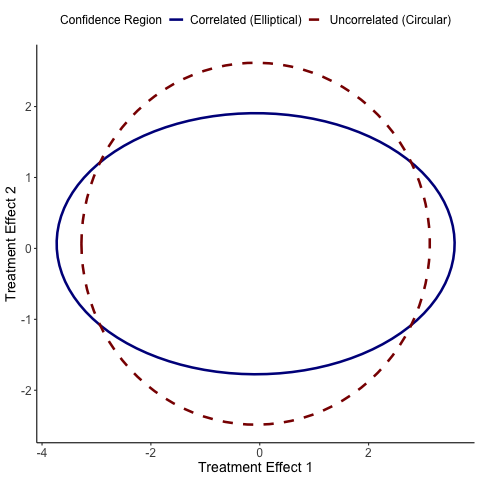

In [32]:

%%R
# Load required libraries
library(car)
library(ggplot2)
library(sp)

# Set seed for reproducibility
set.seed(123)

# Ensure data_final exists
if (!exists("data_final")) {
  stop("data_final does not exist. Please ensure it is loaded.")
}

# Calculate mean vector and covariance matrices
mean_vector <- c(mean(data_final$predictions1_mean, na.rm = TRUE), 
                 mean(data_final$predictions2_mean, na.rm = TRUE))

covariance_matrix <- matrix(c(1.709836, 0.7723078, 
                             0.7723078, 1.086786), nrow = 2, byrow = TRUE)

covariance_matrix_shape <- matrix(c(1.709836, 0, 
                                  0, 1.086786), nrow = 2, byrow = TRUE)


# Confidence level
confidence_level <- 0.95

# Function to create ellipse points
create_ellipse_points <- function(covariance_matrix, mean_vector, confidence_level = 0.95) {
  # Get eigenvalues and eigenvectors
  eigen_decomp <- eigen(covariance_matrix)
  
  # Calculate scaling factor for desired confidence level
  chi_square <- qchisq(confidence_level, df = 2)
  
  # Create circle points
  theta <- seq(0, 2*pi, length.out = 100)
  circle <- cbind(cos(theta), sin(theta))
  
  # Scale circle to ellipse
  scaling <- sqrt(chi_square * eigen_decomp$values)
  ellipse <- t(mean_vector + (t(eigen_decomp$vectors %*% diag(scaling)) %*% t(circle)))
  
  # Return as data frame
  return(data.frame(x = ellipse[,1], y = ellipse[,2]))
}

# Create ellipse data for both cases
ellipse_corr <- create_ellipse_points(
  covariance_matrix = covariance_matrix,
  mean_vector = mean_vector,
  confidence_level = 0.95
)
ellipse_corr$type <- "Correlated (Elliptical)"

ellipse_uncorr <- create_ellipse_points(
  covariance_matrix = covariance_matrix_shape,  # diagonal matrix
  mean_vector = mean_vector,
  confidence_level = 0.95
)
ellipse_uncorr$type <- "Uncorrelated (Circular)"

# Combine ellipse data
ellipse_data <- rbind(ellipse_corr, ellipse_uncorr)

# Create plot
p <- ggplot() +
  geom_path(data = ellipse_data, 
            aes(x = x, y = y, color = type, linetype = type),
            size = 1.2) +
  scale_color_manual(values = c("darkblue", "darkred")) +
  scale_linetype_manual(values = c("solid", "dashed")) +
  labs(x = "Treatment Effect 1",
       y = "Treatment Effect 2",
       color = "Confidence Region",
       linetype = "Confidence Region") +
  theme_classic() +
  theme(
    legend.position = "top",
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14),
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 12)
  )

# Display plot
print(p)

# Save plot if needed
ggsave("confidence_regions.pdf", p, width = 8, height = 6, dpi = 300)